<a href="https://colab.research.google.com/github/joydeep2683/interview_notebooks/blob/master/modista_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary of this notebook:

The goal of this notebook is to create one function which will return us the tag probablities for a particulart dress feature(we will have multiple models) So I created ModistaTagPredictor class. Which will load the models and it's predict_tags method will return the probabilities. Parts of the notebook.


1.   Importing all the necessary modules including mount gdrive
2.   Removing courrpt files
3.   Creating DataLoader with Transformation and batch size
4.   Load a pretrained model(resnet34) then chopoff the 1000 class (imagenet layer) and replace that by number of classes 
5.   Setting model optimizer and losses
6.   Train and plot graph
7.   Predict Classs creation which has both batch and non batch prediction mode


Model training pipeline - Downloaded data from different website. Categorized them with correct tags. 
For example - Sleeve style is the main folder. which has train, test, valid folder. each of which contains a folder for each tag. Data is almost nomalized.

P.S - If you found this notebook difficult to understand, you can contact me.

# **Generic Import**

In [ ]:
from google.colab import drive
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from tqdm import tqdm
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# **Torch Import**

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# **Training Part**

In [ ]:
train_path = 'gdrive/My Drive/training_data/image_data/train/'
test_path = 'gdrive/My Drive/training_data/image_data/test/' 
valid_path = 'gdrive/My Drive/training_data/image_data/valid/'  

In [ ]:
os.listdir(train_path)

['cold-shoulder-sleeves',
 'flared-sleeves',
 'no-sleeves',
 'regular-sleeves',
 'cap-sleeves']

Removing corrupt images

In [ ]:
def remove_corrupt(folder_path):
    for folder in os.listdir(folder_path):
        folder = folder_path+folder+'/'
        for img in tqdm(os.listdir(folder)):
            img = folder+'/'+img
            try:
                Image.open(img)
            except:
                print("corrupt image", img)
                os.remove(img)

Do the next line only once

In [ ]:
# remove_corrupt(train_path)
# remove_corrupt(test_path)
# remove_corrupt(valid_path)

  0%|          | 0/101 [00:00<?, ?it/s]

corrupt image gdrive/My Drive/training_data/image_data/test/flared-sleeves//.DS_Store


  0%|          | 0/101 [00:00<?, ?it/s]

corrupt image gdrive/My Drive/training_data/image_data/test/cold-shoulder-sleeves//.DS_Store


  0%|          | 0/101 [00:00<?, ?it/s]

corrupt image gdrive/My Drive/training_data/image_data/test/cap-sleeves//.DS_Store


  0%|          | 0/101 [00:00<?, ?it/s]

corrupt image gdrive/My Drive/training_data/image_data/test/regular-sleeves//.DS_Store


100%|██████████| 101/101 [00:04<00:00, 21.51it/s]

corrupt image gdrive/My Drive/training_data/image_data/test/no-sleeves//.DS_Store


# DataLoader and Transformation

In [ ]:
transform = transforms.Compose([transforms.Resize(224), 
                transforms.CenterCrop(224),  
                # transforms.RandomHorizontalFlip(),
                transforms.ToTensor(), 
                # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])
bs = 128
train_dataset = torchvision.datasets.ImageFolder(
        root=train_path,
        transform=transform
    )
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs,
                                          shuffle=True, num_workers=1)

test_dataset = torchvision.datasets.ImageFolder(
        root=test_path,
        transform=transform
    )
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs,
                                          shuffle=True, num_workers=1)

valid_dataset = torchvision.datasets.ImageFolder(
        root=valid_path,
        transform=transform
    )
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=bs,
                                          shuffle=True, num_workers=1)


In [ ]:
classes = train_dataset.classes

In [ ]:
# you need to keep this classes as tags in model config in same order
classes

['cap-sleeves',
 'cold-shoulder-sleeves',
 'flared-sleeves',
 'no-sleeves',
 'regular-sleeves']

(3, 228, 906)


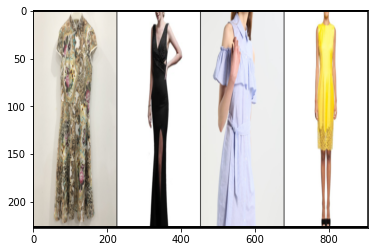

cap-sleeves no-sleeves cold-shoulder-sleeves no-sleeves


In [ ]:
# functions to show an image after transformation

def imshow(img):
    npimg = img.numpy()
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)), aspect='auto')
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


# Pretrained model loading and last layer adjustment

In [ ]:
# Loading pretrained model with weights
model = torchvision.models.resnet34(pretrained=True, progress=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
# chopping the 1000 class (imagenet layer) and replace that by number of classes
model.fc = nn.Linear(512, len(classes))

# setting model optimizer and losses
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda


In [ ]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# TRAINING

In [ ]:
epochs = 2
steps = 0
running_loss = 0
print_every = 2
train_losses, valid_losses = [], []

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    valid_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
 
            train_losses.append(running_loss/len(trainloader))
            valid_losses.append(valid_loss/len(validloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Valid loss: {valid_loss/len(validloader):.3f}.. "
                  f"Valid accuracy: {accuracy/len(validloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/2.. Train loss: 1.824.. Valid loss: 1.726.. Valid accuracy: 0.215
Epoch 1/2.. Train loss: 1.822.. Valid loss: 1.665.. Valid accuracy: 0.244
Epoch 1/2.. Train loss: 1.659.. Valid loss: 1.733.. Valid accuracy: 0.233
Epoch 1/2.. Train loss: 1.656.. Valid loss: 1.568.. Valid accuracy: 0.299
Epoch 1/2.. Train loss: 1.550.. Valid loss: 1.523.. Valid accuracy: 0.340
Epoch 1/2.. Train loss: 1.585.. Valid loss: 1.512.. Valid accuracy: 0.336
Epoch 1/2.. Train loss: 1.520.. Valid loss: 1.457.. Valid accuracy: 0.364
Epoch 1/2.. Train loss: 1.482.. Valid loss: 1.527.. Valid accuracy: 0.336
Epoch 1/2.. Train loss: 1.566.. Valid loss: 1.507.. Valid accuracy: 0.353
Epoch 1/2.. Train loss: 1.456.. Valid loss: 1.436.. Valid accuracy: 0.380
Epoch 1/2.. Train loss: 1.422.. Valid loss: 1.364.. Valid accuracy: 0.424
Epoch 1/2.. Train loss: 1.494.. Valid loss: 1.379.. Valid accuracy: 0.428
Epoch 1/2.. Train loss: 1.454.. Valid loss: 1.320.. Valid accuracy: 0.480
Epoch 1/2.. Train loss: 1.311.. Valid 

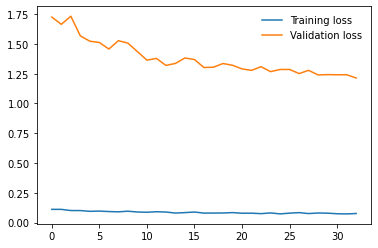

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
epochs = 30
steps = 0
running_loss = 0
print_every = 2
train_losses, valid_losses = [], []

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    valid_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
 
            train_losses.append(running_loss/len(trainloader))
            valid_losses.append(valid_loss/len(validloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Valid loss: {valid_loss/len(validloader):.3f}.. "
                  f"Valid accuracy: {accuracy/len(validloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/30.. Train loss: 1.141.. Valid loss: 1.223.. Valid accuracy: 0.481
Epoch 1/30.. Train loss: 1.171.. Valid loss: 1.240.. Valid accuracy: 0.452
Epoch 1/30.. Train loss: 1.174.. Valid loss: 1.234.. Valid accuracy: 0.488
Epoch 1/30.. Train loss: 1.192.. Valid loss: 1.241.. Valid accuracy: 0.513
Epoch 1/30.. Train loss: 1.104.. Valid loss: 1.310.. Valid accuracy: 0.436
Epoch 1/30.. Train loss: 1.224.. Valid loss: 1.256.. Valid accuracy: 0.505
Epoch 1/30.. Train loss: 1.256.. Valid loss: 1.199.. Valid accuracy: 0.496
Epoch 1/30.. Train loss: 1.171.. Valid loss: 1.222.. Valid accuracy: 0.480
Epoch 1/30.. Train loss: 1.212.. Valid loss: 1.217.. Valid accuracy: 0.477
Epoch 1/30.. Train loss: 1.241.. Valid loss: 1.202.. Valid accuracy: 0.532
Epoch 1/30.. Train loss: 1.198.. Valid loss: 1.212.. Valid accuracy: 0.516
Epoch 1/30.. Train loss: 1.193.. Valid loss: 1.181.. Valid accuracy: 0.545
Epoch 1/30.. Train loss: 1.243.. Valid loss: 1.217.. Valid accuracy: 0.496
Epoch 1/30.. Train loss: 

KeyboardInterrupt: ignored

Saving The Model

In [ ]:
model_save_path = '/'.join(train_path.split('/')[:-2])+'/'+'model_2.pth'
print(model_save_path)
torch.save(model, model_save_path)

gdrive/My Drive/training_data/image_data/model_2.pth


# **Model config**
This will go to setting file. where for each type of attribute we will have one model and we will have a key value pair for each model

In [ ]:
MODEL_CONFIG = {
  "SLEEVE_STYLE" : {
      "arch": "resnet34",
      "model_file": "gdrive/My Drive/training_data/image_data/model_2.pth",
      "transformation": transforms.Compose([transforms.Resize(255), 
                  transforms.CenterCrop(255),  
                  transforms.RandomHorizontalFlip(),
                  transforms.ToTensor()]),
      "tags": ['cap-sleeves', 'cold-shoulder-sleeves', 'flared-sleeves', 'no-sleeves', 'regular-sleeves'],
  }   
}

In [ ]:
# pred_model = torch.load(model_save_path)
# pred_model.eval()
# img = torch.tensor(cv2.imread('gdrive/My Drive/training_data/image_data/test/cap-sleeves/027bc07290956b873a00f9cb7ca49f01.jpg'))
# # pred_model()

# PREDICTION

Predictor Class

In [ ]:
class ModistaTagPredictor:
    def __init__(self, model_configs):
        self.transform = model_configs['transformation']
        self.tags = model_configs['tags']
        self.pred_model = torch.load(model_configs['model_file'])
        self.pred_model.eval()
        self.bs = 64
        


    def image_loader(self, image_name):
        image = Image.open(image_name)
        image = self.transform(image).float()
        image = Variable(image, requires_grad=True)
        image = image.unsqueeze(0)
        return image.cuda()


    def predict_tags(self, img):
        image = self.image_loader(img)
        out = self.pred_model(image)
        _, predicted = torch.max(out, 1)
        # out = out.detach().cpu().numpy()
        out = torch.nn.functional.softmax(out, 1)
        probs = [float(i) for i in list(out[0])]
        print(sum(probs))
        result = dict(zip(self.tags, probs))
        return result

    def predict_tags_batch(self, img_folder):
        """Not fully functional- Do not Use"""
        img_dataset = torchvision.datasets.ImageFolder(
        root=img_folder,
        transform=self.transform
    )
        imgloader = torch.utils.data.DataLoader(img_dataset, batch_size=self.bs,
                                          shuffle=True, num_workers=1)
        outputs = list()
        since = time.time()
        for inputs, labels in imgloader:
            inputs = inputs.to(device)
            output = model(inputs)
            output = output.to(device)
            index = output.data.numpy().argmax()
            print(index)

Non Batch Prediction

1.0000000344589353


{'cap-sleeves': 0.5681125521659851,
 'cold-shoulder-sleeves': 0.10499761998653412,
 'flared-sleeves': 0.009720523841679096,
 'no-sleeves': 0.14360922574996948,
 'regular-sleeves': 0.17356011271476746}

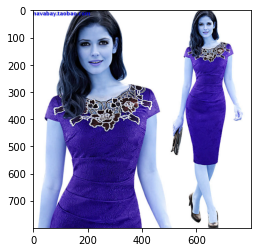

In [ ]:
image_path = 'gdrive/My Drive/training_data/image_data/test/cap-sleeves/027bc07290956b873a00f9cb7ca49f01.jpg'
plt.imshow(cv2.imread(image_path))
f = ModistaTagPredictor(MODEL_CONFIG['SLEEVE_STYLE'])
f.predict_tags(image_path)

Batch Prediction